In [1]:
from pathlib import Path
import pandas as pd

In [2]:
# data[0].keys()
from generate_embeddings import _X_test_viz
import targets
import viz
T = targets.get(90)
X_test = _X_test_viz(T)

In [3]:
from distributed import Client
client = Client()
client

/Users/scott/anaconda3/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 52781 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:52782 Dashboard: http://127.0.0.1:52781/status,Cluster Workers: 4 Cores: 8 Memory: 16.00 GiB


In [49]:
import msgpack

def _cook(raw, fname=None, NEXT=False):
    for r in raw:
        r["meta"]["history_fname"] = fname
        r["meta"]["system"] = fname.split("/")[0]
        
        
        if NEXT:
            rate = fname.split("/")[-1].replace("_history.msgpack", "").replace("rate=", "")
            r["meta"]["rate"] = float(rate)
        else:
            n_search = fname.split("/")[-1].replace("-1_history.msgpack", "").replace("TSTE-n_search=", "")
            r["meta"]["n_search"] = float(n_search)
            r["meta"]["rate"] = 1
        r["meta"]["n_train"] = r["meta"]["n_responses"]
    return raw

data = []
DIR = Path("salmon") / "io" / "2021-05-26-search"

for f in DIR.glob("*_history.msgpack"):
    raw = msgpack.loads(f.read_bytes(), raw=False)
    data.extend(_cook(raw, fname=str(f)))
    
DIR = Path("next") / "io" / "2021-05-24"
for f in DIR.glob("*_history.msgpack"):
    raw = msgpack.loads(f.read_bytes(), raw=False)
    data.extend(_cook(raw, fname=str(f), NEXT=True))
## ARR is not relevant to this comparison
# DIR = Path("salmon") / "io" / "2021-05-25"
# f = DIR / "ARR-1_history.msgpack"
# raw = msgpack.loads(f.read_bytes(), raw=False)
# data.extend(_cook(raw, fname=str(f)))

In [54]:
data[-3]

{'meta': {'n_responses': 21760,
  'delta': 0.01,
  'd': 2,
  'n': 90,
  'alg_id': 'STE',
  'alg_label': 'STE',
  'history_fname': 'next/io/2021-05-24/rate=5_history.msgpack',
  'system': 'next',
  'rate': 5.0,
  'n_train': 21760},
 'embedding': [[6.9494703436580645, 7.79217088370504],
  [9.076461481451318, 6.6133304660285726],
  [4.103154014590113, 8.647271595062406],
  [0.4280796388879849, 12.967433963030558],
  [11.75310810239526, 2.0270010339467865],
  [2.1513608830109243, 10.625175205400787],
  [4.682123462764813, 7.050491965230022],
  [5.65561898753779, 10.227526142145214],
  [0.519456276804424, 11.577783316716411],
  [4.923695675984341, 8.379034123975572],
  [2.7391895581802586, 9.976572437409052],
  [0.23566986339791662, 10.642716196612223],
  [2.3030647368710078, 9.326216036590358],
  [4.3830545951388205, 7.159616867002005],
  [2.167983540189067, 8.581645538736874],
  [1.7027547483758776, 8.114528513619728],
  [2.326948604135724, 8.900690769797313],
  [1.2276616674169398, 8.193

In [14]:
T_f = client.scatter(T)
X_test_f = client.scatter(X_test)
futures = client.map(viz._stats, data, X_test=X_test_f, T=T_f)

In [15]:
from dask.distributed import progress
progress(futures)

VBox()

In [16]:
out = client.gather(futures)

In [17]:
df = pd.DataFrame(out)
df.head()

,accuracy,nn_diff_median,nn_diff_mean,nn_acc,avg_items_closer_than_NN,nn_diff_p99,nn_diff_p98,nn_diff_p95,nn_diff_p90,nn_diff_p80,...,meta__n_search,meta__response_time,meta__n_users,meta__history_fname,meta__system,meta__rate,meta__n_train,meta__delta,meta__alg_id,meta__alg_label
0,0.508779,23.5,29.844444,0.000000,44.444444,73.10,72.00,70.55,64.1,51.0,...,300.0,2.0,2.0,salmon/io/2021-05-26-search/TSTE-n_search=300-...,salmon,1.0,0,NaN,NaN,NaN
1,0.508779,23.5,29.844444,0.000000,44.444444,73.10,72.00,70.55,64.1,51.0,...,300.0,2.0,2.0,salmon/io/2021-05-26-search/TSTE-n_search=300-...,salmon,1.0,54,NaN,NaN,NaN
2,0.508779,23.5,29.844444,0.000000,44.422222,73.10,72.00,70.55,64.1,51.0,...,300.0,2.0,2.0,salmon/io/2021-05-26-search/TSTE-n_search=300-...,salmon,1.0,114,NaN,NaN,NaN
3,0.501229,27.5,28.944444,0.022222,41.711111,78.11,78.00,72.85,66.1,44.2,...,300.0,2.0,2.0,salmon/io/2021-05-26-search/TSTE-n_search=300-...,salmon,1.0,175,NaN,NaN,NaN
4,0.513152,29.0,29.155556,0.022222,44.788889,77.00,69.98,65.20,61.0,49.0,...,300.0,2.0,2.0,salmon/io/2021-05-26-search/TSTE-n_search=300-...,salmon,1.0,233,NaN,NaN,NaN


In [18]:
df.columns

Index(['accuracy', 'nn_diff_median', 'nn_diff_mean', 'nn_acc',
       'avg_items_closer_than_NN', 'nn_diff_p99', 'nn_diff_p98', 'nn_diff_p95',
       'nn_diff_p90', 'nn_diff_p80', 'nn_diff_p70', 'nn_diff_p60',
       'nn_diff_p50', 'nn_diff_p40', 'nn_diff_p30', 'nn_diff_p20',
       'nn_diff_p10', 'nn_diff_p5', 'nn_diff_p2', 'nn_diff_p1',
       'embedding_error', 'embedding_rel_error', 'procrustes_disparity',
       'nn_acc_radius_0', 'nn_acc_radius_1', 'nn_acc_radius_2',
       'nn_acc_radius_3', 'nn_acc_radius_4', 'nn_acc_radius_5',
       'nn_acc_radius_6', 'nn_acc_radius_7', 'nn_acc_radius_8',
       'nn_acc_radius_9', 'nn_acc_radius_10', 'nn_acc_radius_11',
       'nn_acc_radius_12', 'nn_acc_radius_13', 'nn_acc_radius_14',
       'nn_acc_radius_15', 'nn_acc_radius_16', 'nn_acc_radius_17',
       'nn_acc_radius_18', 'nn_acc_radius_19', 'nn_acc_radius_20',
       'nn_acc_radius_21', 'nn_acc_radius_22', 'nn_acc_radius_23',
       'nn_acc_radius_24', 'nn_acc_radius_25', 'nn_acc_radiu

In [62]:
import numpy as np
for fname in df.meta__history_fname.unique():
    __d = df[df.meta__history_fname == fname]
    __d = __d.sort_values(by="meta__n_responses")
    static = np.abs(__d.accuracy.diff()) > 0
    __d["change"] = static.astype(bool)

In [63]:
__d["change"]

6678    False
6679     True
6680     True
6681     True
6682     True
        ...  
6933    False
6934    False
6935    False
6936    False
6937    False
Name: change, Length: 260, dtype: bool

650


(0.65, 0.84)

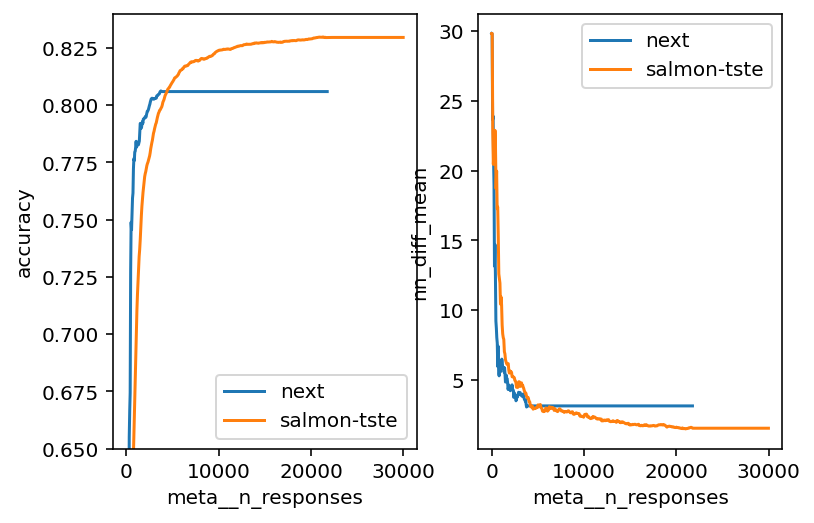

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

nm = "CKL"

idx = (df.meta__system == "next") & (df.meta__rate == 1)
print(idx.sum())
assert df[idx].meta__history_fname.nunique() == 1
__next = df[idx].copy()

n_search = 100
idx = (df.meta__system == "salmon") & (df.meta__n_search == n_search)
assert df[idx].meta__history_fname.nunique() == 1
__salmon = df[idx].copy()

kwargs = dict(x="meta__n_responses")

fig, axs = plt.subplots(ncols=2)

for name, _data in [("next", __next), ("salmon-tste", __salmon)]:
    sns.lineplot(**kwargs, data=_data, y="accuracy", ax=axs[0], label=name)
    sns.lineplot(**kwargs, data=_data, y="nn_diff_mean", ax=axs[1], label=name)
    
axs[0].set_ylim(0.65, 0.84)

In [45]:
__next.tail(n=220)

,accuracy,nn_diff_median,nn_diff_mean,nn_acc,avg_items_closer_than_NN,nn_diff_p99,nn_diff_p98,nn_diff_p95,nn_diff_p90,nn_diff_p80,...,meta__n_search,meta__response_time,meta__n_users,meta__history_fname,meta__system,meta__rate,meta__n_train,meta__delta,meta__alg_id,meta__alg_label
6030,0.805988,3.0,3.133333,0.155556,8.000000,9.0,9.0,8.0,7.0,5.0,...,NaN,NaN,NaN,next/io/2021-05-24/rate=1_history.msgpack,next,1.0,16338,0.01,STE,STE
6031,0.805988,3.0,3.133333,0.155556,7.977778,9.0,9.0,8.0,7.0,5.0,...,NaN,NaN,NaN,next/io/2021-05-24/rate=1_history.msgpack,next,1.0,16364,0.01,STE,STE
6032,0.805988,3.0,3.133333,0.155556,7.977778,9.0,9.0,8.0,7.0,5.0,...,NaN,NaN,NaN,next/io/2021-05-24/rate=1_history.msgpack,next,1.0,16390,0.01,STE,STE
6033,0.805988,3.0,3.133333,0.155556,7.988889,9.0,9.0,8.0,7.0,5.0,...,NaN,NaN,NaN,next/io/2021-05-24/rate=1_history.msgpack,next,1.0,16416,0.01,STE,STE
6034,0.805988,3.0,3.133333,0.155556,7.988889,9.0,9.0,8.0,7.0,5.0,...,NaN,NaN,NaN,next/io/2021-05-24/rate=1_history.msgpack,next,1.0,16442,0.01,STE,STE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6245,0.805988,3.0,3.133333,0.155556,7.977778,9.0,9.0,8.0,7.0,5.0,...,NaN,NaN,NaN,next/io/2021-05-24/rate=1_history.msgpack,next,1.0,21659,0.01,STE,STE
6246,0.805988,3.0,3.133333,0.155556,7.966667,9.0,9.0,8.0,7.0,5.0,...,NaN,NaN,NaN,next/io/2021-05-24/rate=1_history.msgpack,next,1.0,21679,0.01,STE,STE
6247,0.805988,3.0,3.133333,0.155556,7.955556,9.0,9.0,8.0,7.0,5.0,...,NaN,NaN,NaN,next/io/2021-05-24/rate=1_history.msgpack,next,1.0,21699,0.01,STE,STE
6248,0.805988,3.0,3.133333,0.155556,8.011111,9.0,9.0,8.0,7.0,5.0,...,NaN,NaN,NaN,next/io/2021-05-24/rate=1_history.msgpack,next,1.0,21727,0.01,STE,STE


[30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0, 30000.0, 100000.0, 300000.0, nan]


<AxesSubplot:xlabel='meta__n_train', ylabel='accuracy'>

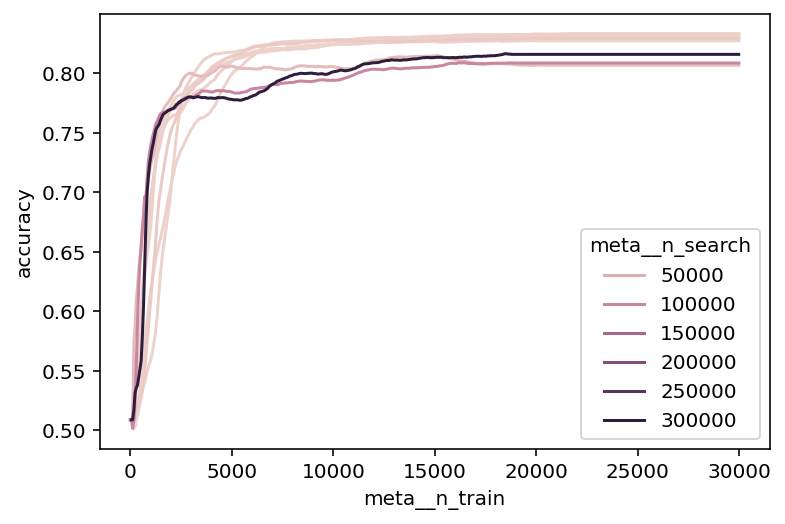

In [20]:


uniq = list(sorted(df.meta__n_search.unique()))
print(uniq)
w = 3
kwargs = dict(
    x="meta__n_train",
)

fig, ax = plt.subplots()
sns.lineplot(
    data=df,
    y="accuracy",
    hue="meta__n_search",
    **kwargs,
)
# fig, axs = plt.subplots(nrows=len(uniq), ncols=2, figsize=(2 * w, len(uniq) * w))
# for u, row in zip(uniq, axs):
#     _ = sns.lineplot(**kwargs, y="accuracy", ax=row[0],  data=df[df.meta__n_search == u])
#     _ = sns.lineplot(**kwargs, y="nn_diff_mean", ax=row[1],  data=df[df.meta__n_search == u])

# for k, row in enumerate(axs):
#     for ax in row:
#         ax.grid(alpha=0.5)
#         ax.legend_.remove()
#     row[0].set_ylim(0.65, 0.835)
#     row[1].set_ylim(0, 9)
#     if k == 0:
#         row[1].legend(loc=(1.05, 0))